In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
# Decision Tree parameter grid
param_grid_dt = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# k-Nearest Neighbors parameter grid
param_grid_knn = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Logistic Regression parameter grid
param_grid_lr = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# List of classifiers with their grids
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, "Logistic Regression")
]


In [16]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

In [17]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # Step 1: Adjust 'k' values so they don't exceed number of features
        adjusted_param_grid = {
            key: [val for val in values if not isinstance(val, int) or val <= n_features]
            for key, values in param_grid.items()
        }

        # Step 2: Generate all combinations of hyperparameters
        param_combinations = list(itertools.product(
            *adjusted_param_grid.values()
        ))
        param_keys = list(adjusted_param_grid.keys())

        for params in param_combinations:
            param_dict = dict(zip(param_keys, params))
            auc_scores = []

            # Step 3: Perform cross-validation
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # Build pipeline
                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                # Set current hyperparameters
                pipeline.set_params(**param_dict)

                # Train on training fold
                pipeline.fit(X_tr, y_tr)

                # Predict probabilities for AUC
                y_proba = pipeline.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_proba)
                auc_scores.append(auc)

            mean_auc = np.mean(auc_scores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = param_dict

        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        # Create the final pipeline with best params
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        best_estimators[name] = final_pipeline

    return best_estimators

In [18]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Step 1: Adjust 'k' values so they don't exceed number of features
        adjusted_param_grid = {
            key: [val for val in values if not isinstance(val, int) or val <= n_features]
            for key, values in param_grid.items()
        }

        # Step 2: Create pipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Step 3: Define StratifiedKFold CV
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Step 4: Run GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        # Step 5: Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

In [19]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

In [20]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION

--- Manual Grid Search for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best cross-validation AUC: 0.7087

--- Manual Grid Search for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for kNN: {'feature_selection__k': 10, 'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Best cross-validation AUC: 0.7303

--- Manual Grid Search for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Logistic Regression: {'feature_selection__k': 'all', 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation AUC: 0.8329

EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8163
  Precision: 0.3684
  Recall: 0.1972
  F1-Score: 0.2569
  ROC AUC: 0.7029

kNN:
  Accuracy: 0.8277
  Precision: 0.4242
  Recall: 0.1972
  F1-Score: 0.2692
  ROC AUC: 0.7340

Logistic Regression:
  Accuracy: 0.8798
  Precision: 0.7368
  Recall: 0.3944
  F1-Score: 0.5138
  ROC AUC: 0.8187

--- Manual Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.8367, Precision: 0.4839
  Recall: 0.2113, F1: 0.2941, AUC: 0.8039


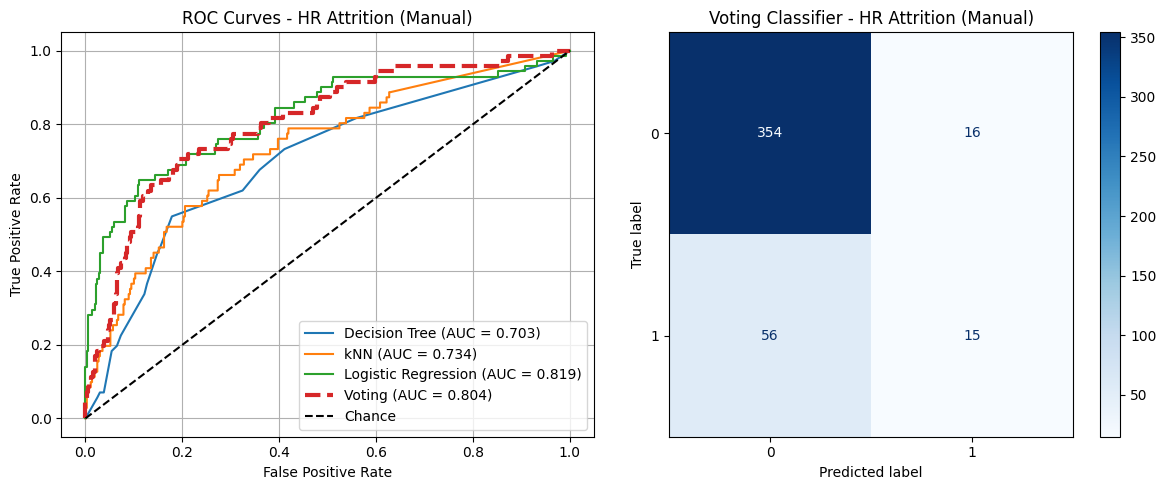


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV score: 0.7087

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.7303

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 'all'}
Best CV score: 0.8329

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8163
  Precision: 0.3684
  Recall: 0.1972
  F1-Score: 0.2569
  ROC AUC: 0.7029

kNN:
  Accuracy: 0.8277
  Precision: 0.4242
  Recall: 0.1972
  F1-Score: 0.2692
  ROC AUC: 0.7340

Logistic Regression:
  Accuracy: 0.8798
  Precision: 0.7368
  Recall: 0.3944
  F1-Score: 0.5138
  ROC AUC: 0.8187

--- Built-in Voting Classifier ---
Error processing HR Attrition: name 'X_train' is not defined

ALL DATASETS PROCESSED!


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [21]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_hr_attrition, "HR Attrition")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)